In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Oct 16 13:59:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              43W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
!pip install transformers

In [3]:
import numpy as np
import pandas as pd
import torch
import time
import datetime
import random
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score, roc_curve
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from transformers import ElectraForSequenceClassification, ElectraTokenizerFast
from transformers import BertConfig
from transformers import TFSequenceSummary
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset
from torch.optim import AdamW

In [4]:
data0 = pd.read_csv('/content/drive/MyDrive/Makale-29-4-23/Dataset0.csv')
data1 = pd.read_csv('/content/drive/MyDrive/Makale-29-4-23/Dataset1.csv')
data2 = pd.read_csv('/content/drive/MyDrive/Makale-29-4-23/Dataset2.csv')
data3 = pd.read_csv('/content/drive/MyDrive/Makale-29-4-23/Dataset3.csv')
data4 = pd.read_csv('/content/drive/MyDrive/Makale-29-4-23/Dataset4.csv')

In [5]:
data = pd.concat([data0, data1], ignore_index=True)
data = pd.concat([data, data3], ignore_index=True)
data = pd.concat([data, data4], ignore_index=True)
test = data2

In [6]:
def Metrics(y_test, y_pred):
  cm = confusion_matrix(y_test, y_pred)
  acc = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  pr = precision_score(y_test, y_pred)
  rc = recall_score(y_test, y_pred)
  kappa = cohen_kappa_score(y_test, y_pred)
  auc = roc_auc_score(y_test, y_pred)
  fpr, tpr, thresholds = roc_curve(y_test, y_pred)
  return cm, acc, f1, pr, rc, kappa, auc, fpr, tpr, thresholds

In [7]:
def Tokenize(tweets, labels, tokenizer):
  input_ids = []
  attention_masks = []
  for tweet in tweets:
    encoded_dict = tokenizer.encode_plus(
                        tweet,
                        add_special_tokens = True,
                        max_length = 512, # tokenizer.model_max_length,
                        padding='max_length',
                        return_attention_mask = True,
                        return_tensors = 'pt',
                        truncation=True,
                   )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)
  return input_ids, attention_masks, labels

In [8]:
def ret_dataloader():
    batch_size = config["batch_size"]
    print('batch_size = ', batch_size)
    train_dataloader = DataLoader(
                train_dataset,  # The training samples.
                sampler = RandomSampler(train_dataset), # Select batches randomly
                batch_size = batch_size # Trains with this batch size.
            )
    validation_dataloader = DataLoader(
                valid_dataset, # The validation samples.
                sampler = SequentialSampler(valid_dataset), # Pull out batches sequentially.
                batch_size = batch_size # Evaluate with this batch size.
            )
    test_dataloader = DataLoader(
                test_dataset, # The validation samples.
                sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
                batch_size = batch_size # Evaluate with this batch size.
            )
    return train_dataloader,validation_dataloader, test_dataloader

In [9]:
def ret_model(tl_model):
  if tl_model == 'electra':
    model = ElectraForSequenceClassification.from_pretrained("google/electra-base-discriminator", num_labels = 2, ignore_mismatched_sizes=True)
  return model

In [10]:
def ret_optim(model):
    print('Learning_rate = ', config["learning_rate"] )
    optimizer = AdamW(model.parameters(),
                      lr = config["learning_rate"],
                      eps = 1e-8
                    )
    return optimizer

In [11]:
def ret_scheduler(train_dataloader,optimizer):
    epochs = config["epochs"]
    print('epochs =>', epochs)

    total_steps = len(train_dataloader) * epochs

    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                                num_training_steps = total_steps)
    return scheduler

In [12]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [13]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [14]:
torch.multiprocessing.set_start_method('spawn', force=True)

In [15]:
def Run(tl_model):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = ret_model(tl_model)
  model.to(device)
  train_dataloader,validation_dataloader, test_dataloader = ret_dataloader()
  optimizer = ret_optim(model)
  scheduler = ret_scheduler(train_dataloader,optimizer)
  seed_val = 42

  random.seed(seed_val)
  np.random.seed(seed_val)
  #torch.manual_seed(seed_val)
  torch.cuda.manual_seed_all(seed_val)

  training_stats = []

  total_t0 = time.time()
  epochs = config["epochs"]

  for epoch_i in tqdm(range(0, epochs)):


    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0
    model.train()
    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()
        output = model(b_input_ids,
                               token_type_ids=None,
                               attention_mask=b_input_mask,
                               labels=b_labels)
        loss = output[0]
        logits = output[1]
        total_train_loss += loss.item()
        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    # wandb.log({'avg_train_loss':avg_train_loss})

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].cuda()
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            output = model(b_input_ids,
                                    token_type_ids=None,
                                    attention_mask=b_input_mask,
                                    labels=b_labels)
            loss = output[0]
            logits = output[1]

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
        # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    # wandb.log({'val_accuracy':avg_val_accuracy,'avg_val_loss':avg_val_loss})
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

  print("")
  print("Training complete!")
  print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
  return model

In [16]:
X = data.processed_tweet.values
y = data.label_enc.values

In [17]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [18]:
print(f"X TRAIN: {len(X_train)}")
print(f"X VALIDATION: {len(X_valid)}")
print(f"X TEST: {len(X_test)}")
print(f"Y TRAIN: {len(y_train)}")
print(f"Y VALIDATION: {len(y_valid)}")
print(f"Y TEST: {len(y_test)}")

X TRAIN: 17593
X VALIDATION: 3770
X TEST: 3770
Y TRAIN: 17593
Y VALIDATION: 3770
Y TEST: 3770


In [19]:
tokenizer_electra = ElectraTokenizerFast.from_pretrained("google/electra-base-discriminator", do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [20]:
config = {
    'learning_rate': 1e-5,
    'batch_size': 32,
    'epochs':10
}

In [21]:
tr_input_ids, tr_attention_masks, y_train = Tokenize(X_train, y_train, tokenizer_electra)
vl_input_ids, vl_attention_masks, y_valid = Tokenize(X_valid, y_valid, tokenizer_electra)
ts_input_ids, ts_attention_masks, y_test = Tokenize(X_test, y_test, tokenizer_electra)

In [22]:
train_dataset = TensorDataset(tr_input_ids, tr_attention_masks, y_train)
valid_dataset = TensorDataset(vl_input_ids, vl_attention_masks, y_valid)
test_dataset = TensorDataset(ts_input_ids, ts_attention_masks, y_test)
print('{:>5,} training samples'.format(len(train_dataset)))
print('{:>5,} validation samples'.format(len(valid_dataset)))
print('{:>5,} test samples'.format(len(test_dataset)))

17,593 training samples
3,770 validation samples
3,770 test samples


In [23]:
import gc
torch.cuda.empty_cache()
gc.collect()
model_electra = Run('electra')

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


batch_size =  32
Learning_rate =  1e-05
epochs => 10


  0%|          | 0/10 [00:00<?, ?it/s]


======== Epoch 1 / 10 ========
Training...
  Batch    40  of    550.    Elapsed: 0:00:28.
  Batch    80  of    550.    Elapsed: 0:00:55.
  Batch   120  of    550.    Elapsed: 0:01:22.
  Batch   160  of    550.    Elapsed: 0:01:49.
  Batch   200  of    550.    Elapsed: 0:02:16.
  Batch   240  of    550.    Elapsed: 0:02:43.
  Batch   280  of    550.    Elapsed: 0:03:10.
  Batch   320  of    550.    Elapsed: 0:03:37.
  Batch   360  of    550.    Elapsed: 0:04:04.
  Batch   400  of    550.    Elapsed: 0:04:31.
  Batch   440  of    550.    Elapsed: 0:04:59.
  Batch   480  of    550.    Elapsed: 0:05:26.
  Batch   520  of    550.    Elapsed: 0:05:53.

  Average training loss: 0.32
  Training epoch took: 0:06:13

Running Validation...
  Accuracy: 0.91
  Validation Loss: 0.22
  Validation took: 0:00:26

======== Epoch 2 / 10 ========
Training...
  Batch    40  of    550.    Elapsed: 0:00:27.
  Batch    80  of    550.    Elapsed: 0:00:54.
  Batch   120  of    550.    Elapsed: 0:01:21.
  Batch

In [24]:
def Electra_test(X_test):
  y_pred = []
  for i in range(len(X_test)):
    tweet = X_test[i]
    inputs = tokenizer_electra(tweet, return_tensors="pt", max_length=512, truncation=True)
    inputs.to('cuda')
    res = model_electra(**inputs)
    if res[0].tolist()[0][0] < 0:
      y_pred.append(1)
    else:
      y_pred.append(0)
  return y_pred

In [25]:
y_pred=Electra_test(X_test)

In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.93      0.95      2474
           1       0.88      0.93      0.91      1296

    accuracy                           0.93      3770
   macro avg       0.92      0.93      0.93      3770
weighted avg       0.94      0.93      0.93      3770



Accuracy:  0.9344827586206896
F1 Score:  0.9074559760209816
Kappa:  0.8568130033395281
Precision:  0.8820101966496723
Recall:  0.9344135802469136
Roc Auc:  0.9344662889108455


<Axes: >

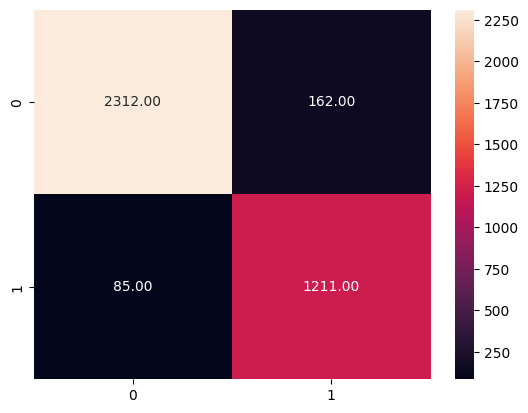

In [27]:
cm_el, acc_el, f1_el, pr_el, rc_el, kappa_el, auc_el, fpr_el, tpr_el, th_el = Metrics(y_test, y_pred)
print("Accuracy: ", acc_el)
print("F1 Score: ", f1_el)
print("Kappa: ", kappa_el)
print("Precision: ", pr_el)
print("Recall: ", rc_el)
print("Roc Auc: ", auc_el)
sns.heatmap(cm_el, annot=True, fmt='.2f')

In [28]:
test_X = test.processed_tweet.values
test_y = test.label_enc.values

In [29]:
y_pred=Electra_test(test_X)

In [30]:
print(classification_report(test_y, y_pred))

              precision    recall  f1-score   support

           0       0.51      0.57      0.54      2099
           1       0.66      0.61      0.63      2902

    accuracy                           0.59      5001
   macro avg       0.59      0.59      0.59      5001
weighted avg       0.60      0.59      0.59      5001



Accuracy:  0.5906818636272746
F1 Score:  0.6326933429032837
Kappa:  0.17230163851505276
Precision:  0.6600524148259079
Recall:  0.607512060647829
Roc Auc:  0.5874625572414943


<Axes: >

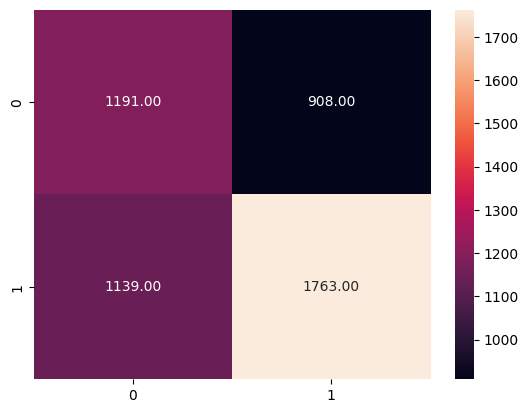

In [31]:
cm_el_t, acc_el_t, f1_el_t, pr_el_t, rc_el_t, kappa_el_t, auc_el_t, fpr_el_t, tpr_el_t, th_el_t = Metrics(test_y, y_pred)
print("Accuracy: ", acc_el_t)
print("F1 Score: ", f1_el_t)
print("Kappa: ", kappa_el_t)
print("Precision: ", pr_el_t)
print("Recall: ", rc_el_t)
print("Roc Auc: ", auc_el_t)
sns.heatmap(cm_el_t, annot=True, fmt='.2f')

In [ ]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn import tree

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
def MLPip(mla):
  pipeline = Pipeline([
      ('bow', CountVectorizer()),
      ('tfidf', TfidfTransformer()),
      ('c', mla)])
  pipeline.fit(X_train, y_train)
  return pipeline

Accuracy:  0.9225464190981433
F1 Score:  0.8845849802371543


<Axes: >

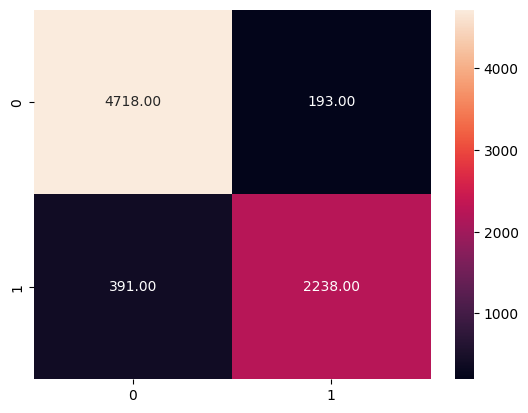

In [ ]:
pipelineSVC = MLPip(SVC())
y_pred_svc = pipelineSVC.predict(X_test)

cm_svc, acc_svc, f1_svc, pr_svc, rc_svc, kappa_svc, auc_svc, fpr_svc, tpr_svc, th_svc = Metrics(y_test, y_pred_svc)
print("Accuracy: ", acc_svc)
print("F1 Score: ", f1_svc)
sns.heatmap(cm_svc, annot=True, fmt='.2f')

Accuracy:  0.46430713857228556
F1 Score:  0.21229050279329612


<Axes: >

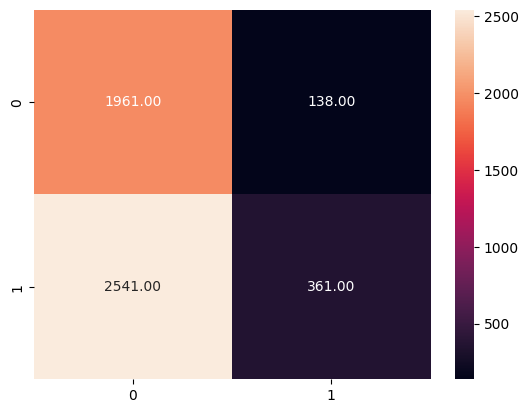

In [ ]:
y_pred_svc = pipelineSVC.predict(test_X)

cm_svc_t, acc_svc_t, f1_svc_t, pr_svc_t, rc_svc_t, kappa_svc_t, auc_svc_t, fpr_svc_t, tpr_svc_t, th_svc_t = Metrics(test_y, y_pred_svc)
print("Accuracy: ", acc_svc_t)
print("F1 Score: ", f1_svc_t)
sns.heatmap(cm_svc_t, annot=True, fmt='.2f')

Accuracy:  0.8561007957559682
F1 Score:  0.7935299714557564


<Axes: >

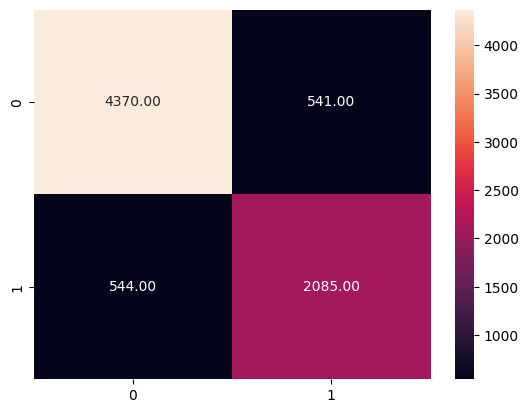

In [ ]:
pipelineDT = MLPip(tree.DecisionTreeClassifier())
y_pred_dt = pipelineDT.predict(X_test)

cm_dt, acc_dt, f1_dt, pr_dt, rc_dt, kappa_dt, auc_dt, fpr_dt, tpr_dt, th_dt = Metrics(y_test, y_pred_dt)
print("Accuracy: ", acc_dt)
print("F1 Score: ", f1_dt)
sns.heatmap(cm_dt, annot=True, fmt='.2f')

Accuracy:  0.4887022595480904
F1 Score:  0.3644046731295053


<Axes: >

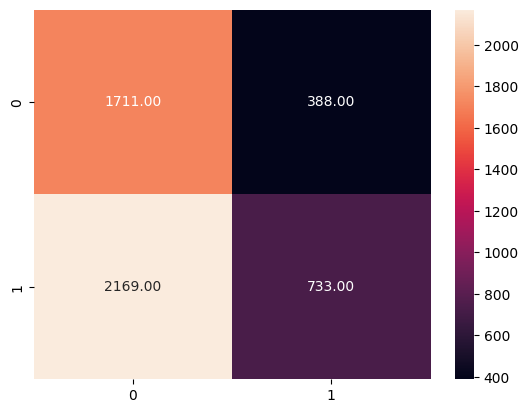

In [ ]:
y_pred_dt = pipelineDT.predict(test_X)

cm_dt_t, acc_dt_t, f1_dt_t, pr_dt_t, rc_dt_t, kappa_dt_t, auc_dt_t, fpr_dt_t, tpr_dt_t, th_dt_t = Metrics(test_y, y_pred_dt)
print("Accuracy: ", acc_dt_t)
print("F1 Score: ", f1_dt_t)
sns.heatmap(cm_dt_t, annot=True, fmt='.2f')

Accuracy:  0.9045092838196287
F1 Score:  0.8579881656804734


<Axes: >

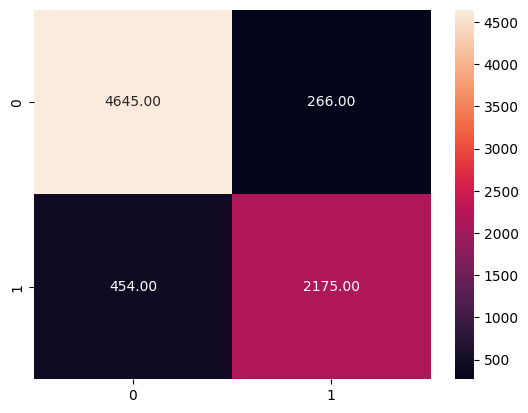

In [ ]:
pipelineRF = MLPip(RandomForestClassifier())
y_pred_rf = pipelineRF.predict(X_test)

cm_rf, acc_rf, f1_rf, pr_rf, rc_rf, kappa_rf, auc_rf, fpr_rf, tpr_rf, th_rf = Metrics(y_test, y_pred_rf)
print("Accuracy: ", acc_rf)
print("F1 Score: ", f1_rf)
sns.heatmap(cm_rf, annot=True, fmt='.2f')

Accuracy:  0.4289142171565687
F1 Score:  0.05555555555555556


<Axes: >

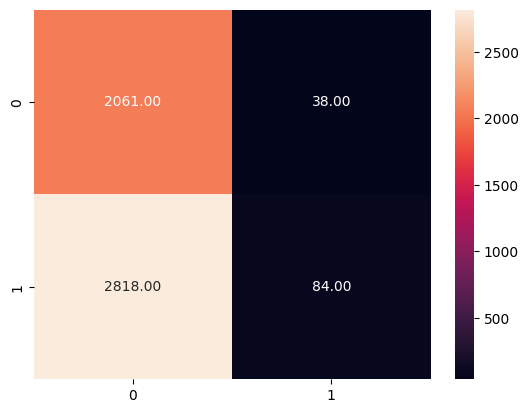

In [ ]:
y_pred_rf = pipelineRF.predict(test_X)

cm_rf_t, acc_rf_t, f1_rf_t, pr_rf_t, rc_rf_t, kappa_rf_t, auc_rf_t, fpr_rf_t, tpr_rf_t, th_rf_t = Metrics(test_y, y_pred_rf)
print("Accuracy: ", acc_rf_t)
print("F1 Score: ", f1_rf_t)
sns.heatmap(cm_rf_t, annot=True, fmt='.2f')

Accuracy:  0.8948275862068965
F1 Score:  0.8393761393558842


<Axes: >

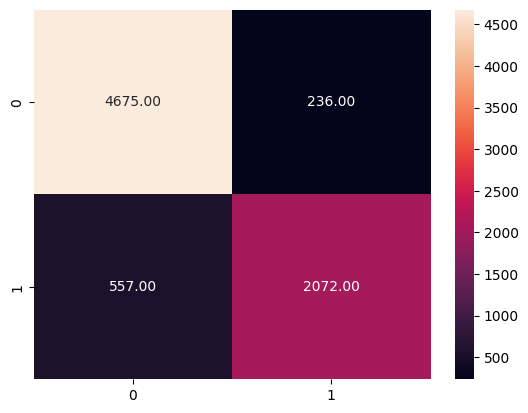

In [ ]:
pipelineXGB = MLPip(xgb.XGBClassifier())
y_pred_xgb = pipelineXGB.predict(X_test)

cm_xgb, acc_xgb, f1_xgb, pr_xgb, rc_xgb, kappa_xgb, auc_xgb, fpr_xgb, tpr_xgb, th_xgb = Metrics(y_test, y_pred_xgb)
print("Accuracy: ", acc_xgb)
print("F1 Score: ", f1_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='.2f')

Accuracy:  0.4417116576684663
F1 Score:  0.11082802547770701


<Axes: >

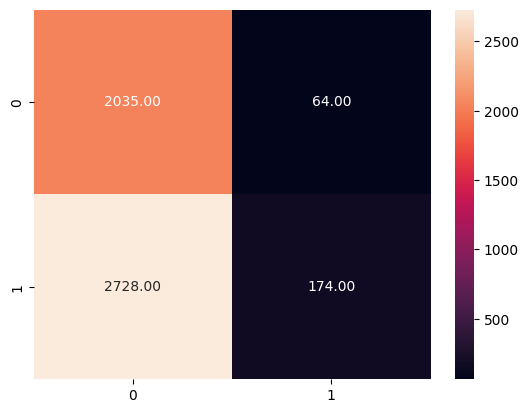

In [ ]:
y_pred_xgb = pipelineXGB.predict(test_X)

cm_xgb_t, acc_xgb_t, f1_xgb_t, pr_xgb_t, rc_xgb_t, kappa_xgb_t, auc_xgb_t, fpr_xgb_t, tpr_xgb_t, th_xgb_t = Metrics(test_y, y_pred_xgb)
print("Accuracy: ", acc_xgb_t)
print("F1 Score: ", f1_xgb_t)
sns.heatmap(cm_xgb_t, annot=True, fmt='.2f')

Accuracy:  0.8957559681697612
F1 Score:  0.8449092344119967


<Axes: >

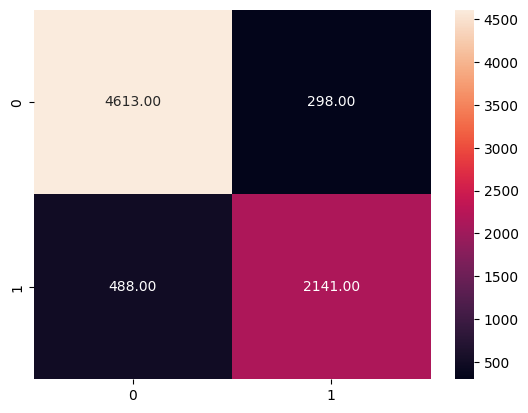

In [ ]:
pipelineKNN = MLPip(KNeighborsClassifier())
y_pred_knn = pipelineKNN.predict(X_test)

cm_knn, acc_knn, f1_knn, pr_knn, rc_knn, kappa_knn, auc_knn, fpr_knn, tpr_knn, th_knn = Metrics(y_test, y_pred_knn)
print("Accuracy: ", acc_knn)
print("F1 Score: ", f1_knn)
sns.heatmap(cm_knn, annot=True, fmt='.2f')

Accuracy:  0.489502099580084
F1 Score:  0.4072440213605758


<Axes: >

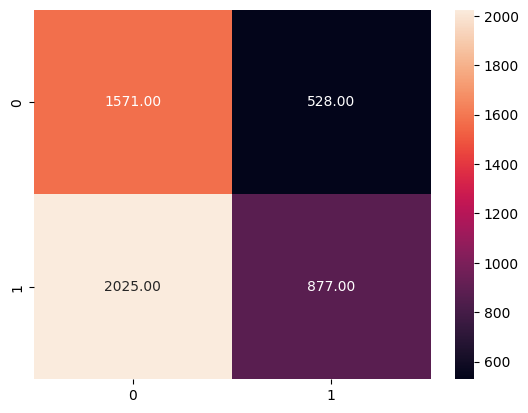

In [ ]:
y_pred_knn = pipelineKNN.predict(test_X)

cm_knn_t, acc_knn_t, f1_knn_t, pr_knn_t, rc_knn_t, kappa_knn_t, auc_knn_t, fpr_knn_t, tpr_knn_t, th_knn_t = Metrics(test_y, y_pred_knn)
print("Accuracy: ", acc_knn_t)
print("F1 Score: ", f1_knn_t)
sns.heatmap(cm_knn_t, annot=True, fmt='.2f')

In [ ]:
models_test = pd.DataFrame({
    'Model': ['Electra', 'Support Vector Machines', 'Decision Tree',  'Random Forest', 'XGBoost', 'KNN'],
    'Accuracy': [acc_el_t, acc_svc_t, acc_dt_t, acc_rf_t, acc_xgb_t, acc_knn_t],
    'Precision': [pr_el_t*100, pr_svc_t*100, pr_dt_t*100, pr_rf_t*100, pr_xgb_t*100, pr_knn_t*100],
    'Recall': [rc_el_t*100, rc_svc_t*100, rc_dt_t*100, rc_rf_t*100, rc_xgb_t*100, rc_knn_t*100],
    'Roc Auc': [auc_el_t*100, auc_svc_t*100, auc_dt_t*100, auc_rf_t*100, auc_xgb_t*100, auc_knn_t*100],
    'F1 Score': [f1_el_t*100, f1_svc_t*100, f1_dt_t*100, f1_rf_t*100, f1_xgb_t*100, f1_knn_t*100],
    'Cohen Kappa Score': [kappa_el_t*100, kappa_svc_t*100, kappa_dt_t*100, kappa_rf_t*100, kappa_xgb_t*100, kappa_knn_t*100]})
models_test.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy,Precision,Recall,Roc Auc,F1 Score,Cohen Kappa Score
0,Electra,0.600680,65.695456,65.265334,59.073830,65.479689,18.124960
5,KNN,0.489502,62.419929,30.220538,52.532851,40.724402,4.610747
2,Decision Tree,0.488702,65.388046,25.258442,53.386725,36.440467,6.061837
1,Support Vector Machines,0.464307,72.344689,12.439697,52.932569,21.229050,5.063178
4,XGBoost,0.441712,73.109244,5.995865,51.473397,11.082803,2.506642
3,Random Forest,0.428914,68.852459,2.894555,50.542085,5.555556,0.916272


In [ ]:
models = pd.DataFrame({
    'Model': ['Electra', 'Support Vector Machines', 'Decision Tree',  'Random Forest', 'XGBoost', 'KNN'],
    'Accuracy': [acc_el, acc_svc, acc_dt, acc_rf, acc_xgb, acc_knn],
    'Precision': [pr_el*100, pr_svc*100, pr_dt*100, pr_rf*100, pr_xgb*100, pr_knn*100],
    'Recall': [rc_el*100, rc_svc*100, rc_dt*100, rc_rf*100, rc_xgb*100, rc_knn*100],
    'Roc Auc': [auc_el*100, auc_svc*100, auc_dt*100, auc_rf*100, auc_xgb*100, auc_knn*100],
    'F1 Score': [f1_el*100, f1_svc*100, f1_dt*100, f1_rf*100, f1_xgb*100, f1_knn*100],
    'Cohen Kappa Score': [kappa_el*100, kappa_svc*100, kappa_dt*100, kappa_rf*100, kappa_xgb*100, kappa_knn*100]})
models.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy,Precision,Recall,Roc Auc,F1 Score,Cohen Kappa Score
0,Electra,0.937401,88.294798,94.290123,93.871012,91.194030,86.346181
1,Support Vector Machines,0.922546,92.060880,85.127425,90.598736,88.458498,82.643575
3,Random Forest,0.904509,89.102827,82.731076,88.657332,85.798817,78.620898
5,KNN,0.895756,87.781878,81.437809,87.684899,84.490923,76.656952
4,XGBoost,0.894828,89.774697,78.813237,87.003849,83.937614,76.168452
2,Decision Tree,0.856101,79.398324,79.307722,84.145818,79.352997,68.309746


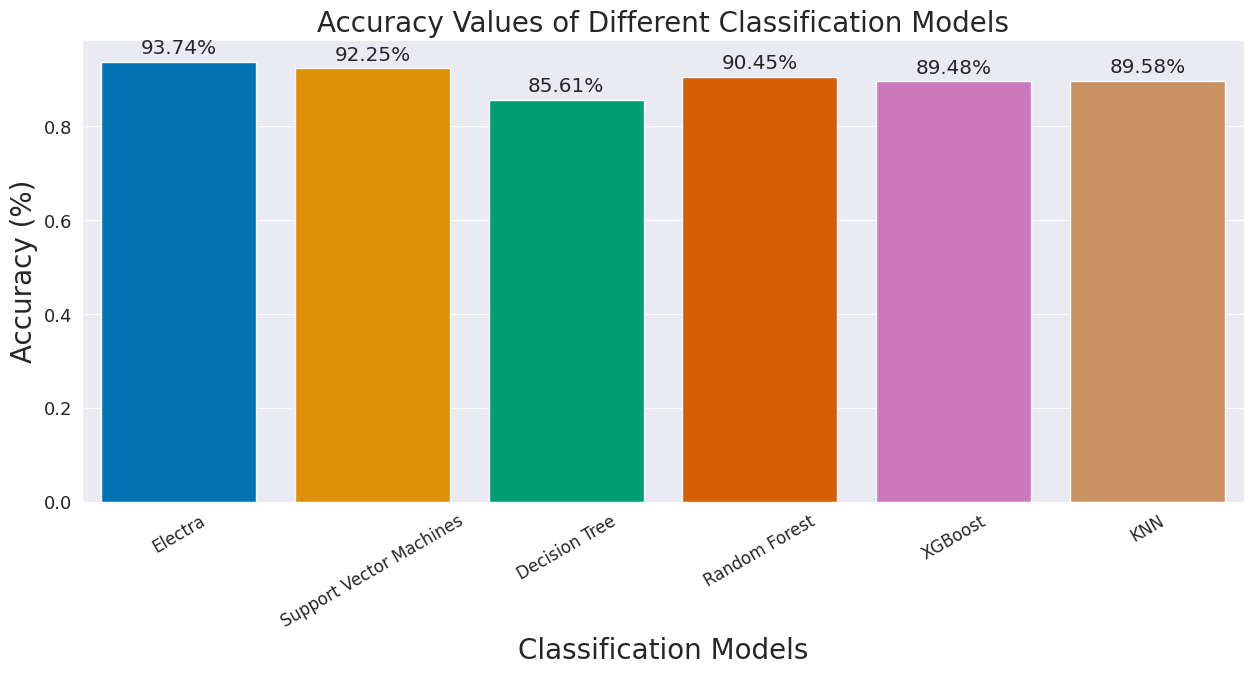

In [ ]:
plt.rcParams['figure.figsize']=15,6
sns.set_style("darkgrid")
ax = sns.barplot(x=models.Model, y=models.Accuracy, palette = "colorblind", saturation =1.5)
plt.xlabel("Classification Models", fontsize = 20 )
plt.ylabel("Accuracy (%)", fontsize = 20)
plt.title("Accuracy Values of Different Classification Models", fontsize = 20)
plt.xticks(fontsize = 12, horizontalalignment = 'center', rotation = 30)
plt.yticks(fontsize = 13)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height:.2%}', (x + width/2, y + height*1.02), ha='center', fontsize = 'x-large')
plt.show()

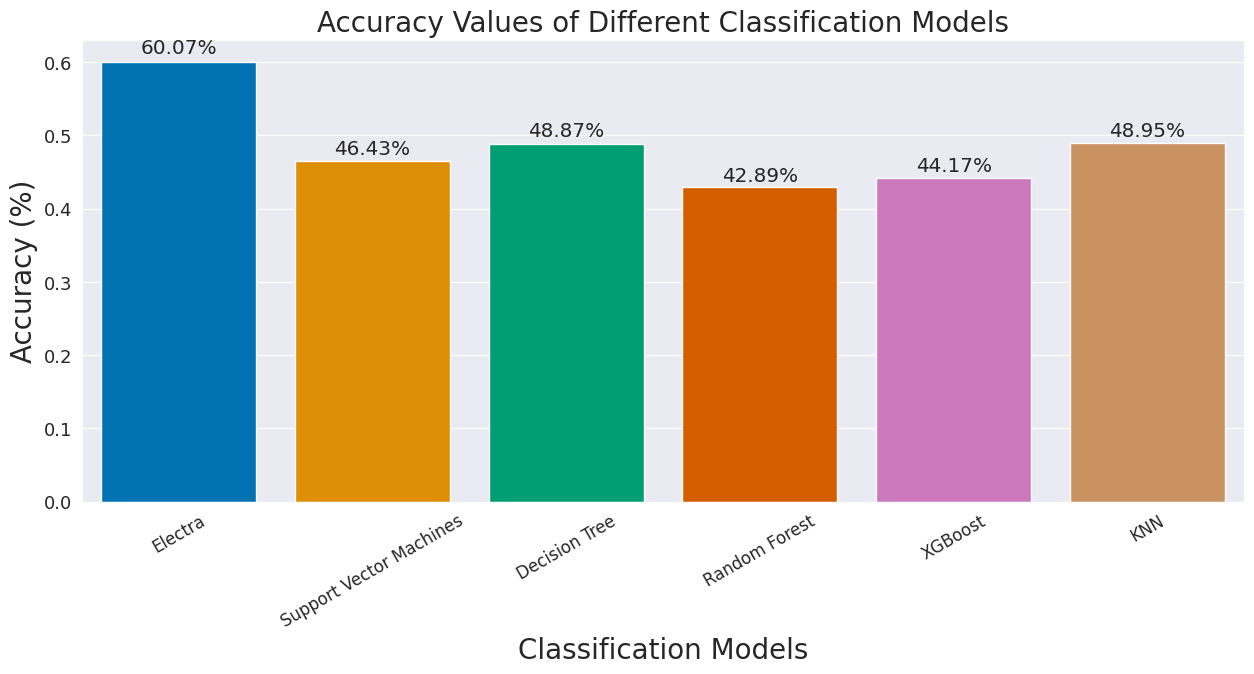

In [ ]:
plt.rcParams['figure.figsize']=15,6
sns.set_style("darkgrid")
ax = sns.barplot(x=models_test.Model, y=models_test.Accuracy, palette = "colorblind", saturation =1.5)
plt.xlabel("Classification Models", fontsize = 20 )
plt.ylabel("Accuracy (%)", fontsize = 20)
plt.title("Accuracy Values of Different Classification Models", fontsize = 20)
plt.xticks(fontsize = 12, horizontalalignment = 'center', rotation = 30)
plt.yticks(fontsize = 13)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height:.2%}', (x + width/2, y + height*1.02), ha='center', fontsize = 'x-large')
plt.show()

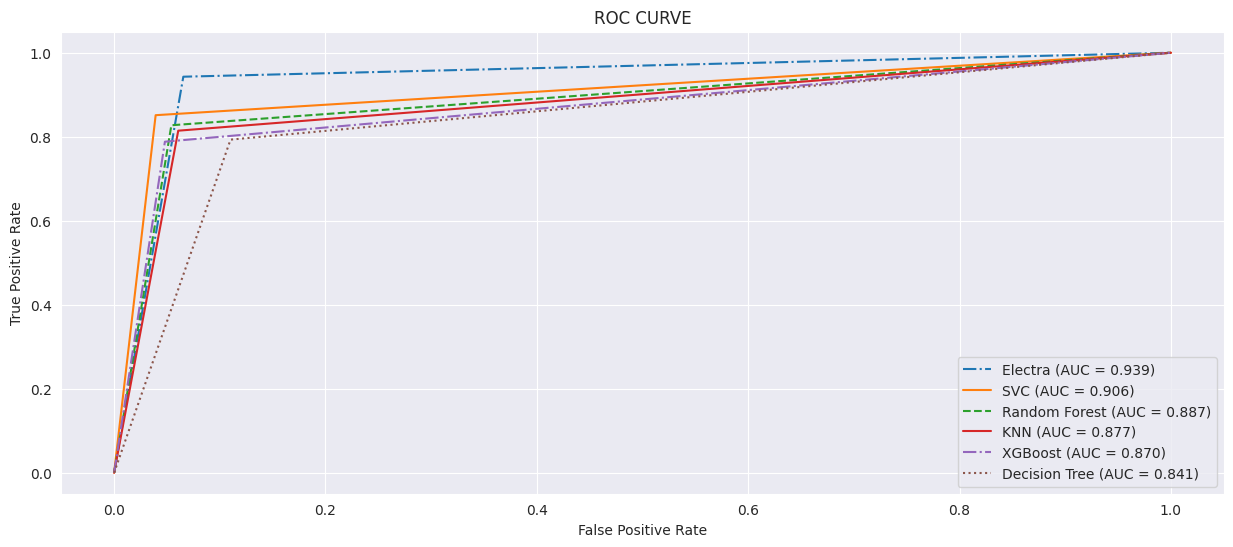

In [ ]:
plt.plot(fpr_el, tpr_el, linestyle='-.', label='Electra (AUC = %.3f)' % auc_el)
plt.plot(fpr_svc, tpr_svc, linestyle='-', label='SVC (AUC = %.3f)' % auc_svc)
plt.plot(fpr_rf, tpr_rf, linestyle='--', label='Random Forest (AUC = %.3f)' % auc_rf)
plt.plot(fpr_knn, tpr_knn, linestyle='solid', label='KNN (AUC = %.3f)' % auc_knn)
plt.plot(fpr_xgb, tpr_xgb, linestyle='dashdot', label='XGBoost (AUC = %.3f)' % auc_xgb)
plt.plot(fpr_dt, tpr_dt, linestyle=':', label='Decision Tree (AUC = %.3f)' % auc_dt)
plt.title('ROC CURVE')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

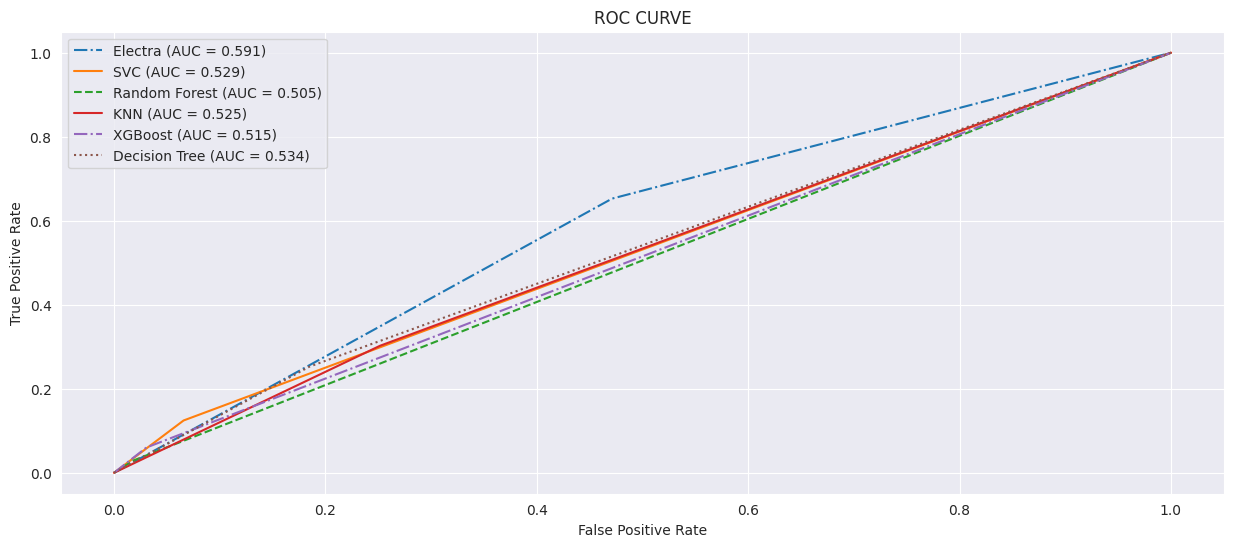

In [ ]:
plt.plot(fpr_el_t, tpr_el_t, linestyle='-.', label='Electra (AUC = %.3f)' % auc_el_t)
plt.plot(fpr_svc_t, tpr_svc_t, linestyle='-', label='SVC (AUC = %.3f)' % auc_svc_t)
plt.plot(fpr_rf_t, tpr_rf_t, linestyle='--', label='Random Forest (AUC = %.3f)' % auc_rf_t)
plt.plot(fpr_knn_t, tpr_knn_t, linestyle='solid', label='KNN (AUC = %.3f)' % auc_knn_t)
plt.plot(fpr_xgb_t, tpr_xgb_t, linestyle='dashdot', label='XGBoost (AUC = %.3f)' % auc_xgb_t)
plt.plot(fpr_dt_t, tpr_dt_t, linestyle=':', label='Decision Tree (AUC = %.3f)' % auc_dt_t)
plt.title('ROC CURVE')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()